
# {{ mandatory }} PCA for shape generation
In this mandatory exercise you will use PCA to generate face shapes. The goal is to have you explore the relation between points in latent space and data space (which in this instance is faces). 

```{warning}
Please read the introduction to PCA in exercise 10.1 carefully and solve the exercises before starting on this assignment. The transformations between data space and latent space are needed for this assigment. However, no questions and task from this asssigment will be about the exercise. However, you are, as always, welcome to ask about the exercise implementation at the dedicated times. 
```


```{note}
{{ answer }} markers indicate where you should write your answers to each question. All enumerated tasks (tasks with preceeding letters) has an answer field if it requires answers in prose.
```

The exercise is subdivided into the following two sections:

- {{ mandatory-task }} {ref}`pca:gen` (questions A-J)
- {{ mandatory-task }} {ref}`pca:reflect` (questions A-B

## Hand-in
You have to write your solutions and answers in this Jupyter Notebook. The hand-in have to be a zip file of the entire exercise folder for this week (including the data!). The assignment is handed in on the LearnIT course page under `assigment 3`. **Additionally**, make sure to only use python packages utilized throughout the course, and not any new libraries that require installation. 

In [160]:
## Importing libraries
import matplotlib.pyplot as plt
import numpy as np
import scipy
import cv2 as cv

import os
from glob import glob

from utils import *
from utils import plot_many_faces

## PCA implementation
Copy your PCA implementation into the following cell:


In [171]:
def get_principle_components(shapes):
    X_meaned = shapes - np.mean(shapes, axis=0)
    
    cov_mat = np.cov(X_meaned, rowvar=False)

    eigen_values , eigen_vectors = np.linalg.eigh(cov_mat)

    #sort the eigenvalues in descending order
    sorted_index = np.argsort(eigen_values)[::-1]
    
    sorted_eigenvalue = eigen_values[sorted_index]
    #similarly sort the eigenvectors 
    sorted_eigenvectors = eigen_vectors[:,sorted_index]

    return sorted_eigenvectors, 1, np.mean(shapes, axis=0)

def transform(shapes, fi, mean):
    #print("Transform:")
    X_meaned = shapes
    #print("fi.T:", np.transpose(fi).shape, "X.T:", np.transpose(X_meaned).shape, "shapes:", shapes.shape)
    X_reduced = np.transpose(np.dot(np.transpose(fi), np.transpose(X_meaned)))
    #print("reducedShape:", X_reduced.shape)
    return X_reduced

def inverse_transform(shapes, fi, mean):
    #print("Inverse_Transform:")
    X_meaned = shapes
    #print("fi:", fi.shape, "X:", X_meaned.shape, "shapes:", shapes.shape, "mean:", mean.shape)
    X_upscaled = np.transpose(np.dot(fi, np.transpose(X_meaned)))
    #print("upscaledShape:", X_upscaled.shape)
    return X_upscaled

In [162]:
def get_principle_components(shapes):
    # # Step 2: Calculating meanvector
    meanVector = np.mean(shapes.T, axis=1)
    
    # Centering samples
    centeredShapes = shapes - meanVector

    # Step 3.b: Computing the covariance matrix
    covarianceMatrix = np.cov(centeredShapes.T)

    # Step 4: Computing eigenvectors and eigenvalues
    eigenValues, eigenVectors = np.linalg.eig(covarianceMatrix)

    # Step 5.1
    # Sort eigenvectors by decreasing eigenvalues
    eigenPairs = [(np.abs(eigenValues[i]), eigenVectors[:,i]) for i in range(len(eigenValues))]
    eigenPairs.sort(key=lambda x: x[0], reverse=True)

    # Step 5.2
    # Creating eigenvector matrix W but with the same k (len(shapes))
    eigenValuesSorted = np.array([x[0] for x in eigenPairs])
    eigenVectorsSorted = np.array([x[1] for x in eigenPairs])
    #print(eigenValuesSorted.shape, eigenVectorsSorted.shape)
    W = eigenVectorsSorted[:len(shapes), :]

    return eigenVectorsSorted, eigenValues, meanVector


# Step 6: Transforming the samples onto the new subspace (wk is expected to be reduced to k dimensions)
# equation trans
def transform(x, wk, u):
    for i in range(len(x)):
        x[i] = x[i] - u[i]
    print("transform:")
    print("wkShape", wk.shape, "xshape", x.shape)
    print("wkReduced", wk[:len(x)].shape)
    b = np.dot(np.transpose(wk), x)
    print("transformResult", b.shape)
    return b

# equation inv
def inverse_transform(b, wk, u):
    print("inverse_transform:")
    print("wkshape", wk.shape, "bshape", b.shape)
    x = np.dot(wk, b)
    for i in range(len(x)):
        x[i] = x[i] + u[i]
    print("inverse_transformResult", x.shape)
    return x

In [163]:
def get_principle_components(shapes):
    # # Step 2: Calculating meanvector
    meanVector = np.mean(shapes, axis=0)
    
    # Centering samples
    centeredShapes = shapes - meanVector

    # Step 3.b: Computing the covariance matrix
    covarianceMatrix = np.cov(centeredShapes, rowvar=False)

    # Step 4: Computing eigenvectors and eigenvalues
    eigenValues, eigenVectors = np.linalg.eigh(covarianceMatrix)

    # Step 5.1
    # Sort eigenvectors by decreasing eigenvalues
    eigenPairs = [(np.abs(eigenValues[i]), eigenVectors[:,i]) for i in range(len(eigenValues))]
    eigenPairs.sort(key=lambda x: x[0], reverse=True)

    # Step 5.2 (modified)
    # Creating eigenvector matrix W but with the same k (len(shapes))
    eigenValuesSorted = np.array([x[0] for x in eigenPairs])
    eigenVectorsSorted = np.array([x[1] for x in eigenPairs])

    W = eigenVectorsSorted[:len(shapes), :]
    
    # Returning the W matrix, eigenValues (I think that was what was meant by val?), and the mean vector (my)
    return eigenVectorsSorted, eigenValues, meanVector


# Step 6: Transforming the samples onto the new subspace (wk is expected to be reduced to k dimensions)
# equation trans
def transform(x, wk, u):
    # Subtracting the mean from all x values
    for i in range(len(x)):
        x[i] = x[i] - u[i]
    b = np.dot(np.transpose(wk), np.transpose(x))
    print(wk.shape, x.shape)
    print(b.shape)
    return np.transpose(b)

# equation inv
def inverse_transform(b, wk, u):
    print("usedshape", wk.shape, "bshape", b.shape)
    x = np.dot(wk, np.transpose(b))
    print(x.shape)
    # Adding back the mean to all x values
    for i in range(len(x)):
        x[i] = x[i] + u[i]
    return np.transpose(x)


## {{ mandatory-task }} Using PCA for shape generation

PCA can be used as a generative process, where
new samples in data space can be generated by transforming a point in latent space. Thus, generating a new face $x$ can be done by using $x = \Phi_{:k} b + \mu$, where $\Phi$ is the matrix of eigenvectors, $b$ is a vector in latent space, and $\mu\in\mathbb{R}^{M}$ is the means of the data space features.

We start at $b=\mathbf{0}$. The variance in each direction can be used to define reasonable boundary values for each principal component. Since $b$ is in latent space, we need to calculate the variance of our transformed data. For each feature space dimension, a range of $[-3\sigma_i, 3\sigma_i]$ is used where $\sigma_i = \sqrt{Var(b_i)}$. Assuming the faces are normally distributed, $\pm 3\sigma$ covers $99.7\%$ of all points. This is shown in {numref}`fig:normal`. 

```{figure} ./img/normal.png
---
name: fig:normal
width: 400px
---
Illustration of a normal distribution. The shaded regions indicate the
area of the distribution covered by 1, 2, 3, and 4, standard deviations
($\sigma$) respectively.
```



A): {{ task-code }} **Get principal components:** Repeat what you did in the _Introduction to PCA_ exercise and compute the principal components $\Phi$ for the face dataset. Verify that your implementation is working correctly by using the `plot_many_faces` function (imported from `utils.py`) to plot $5$ face shapes before and after transforming to and back from latent space.


120
compshape (146, 146)
usedshape (146, 20)
usedshape[:len(x)] (5, 20)
(5, 146)


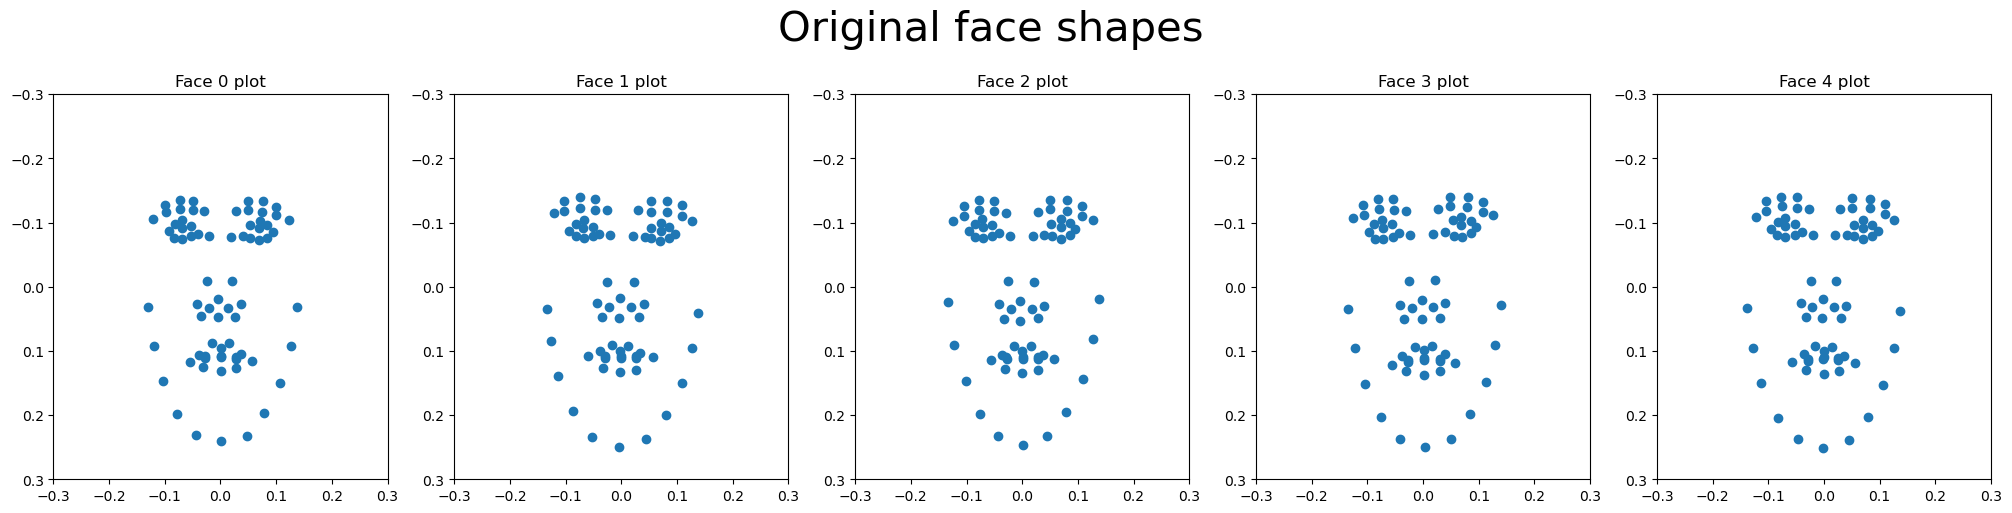

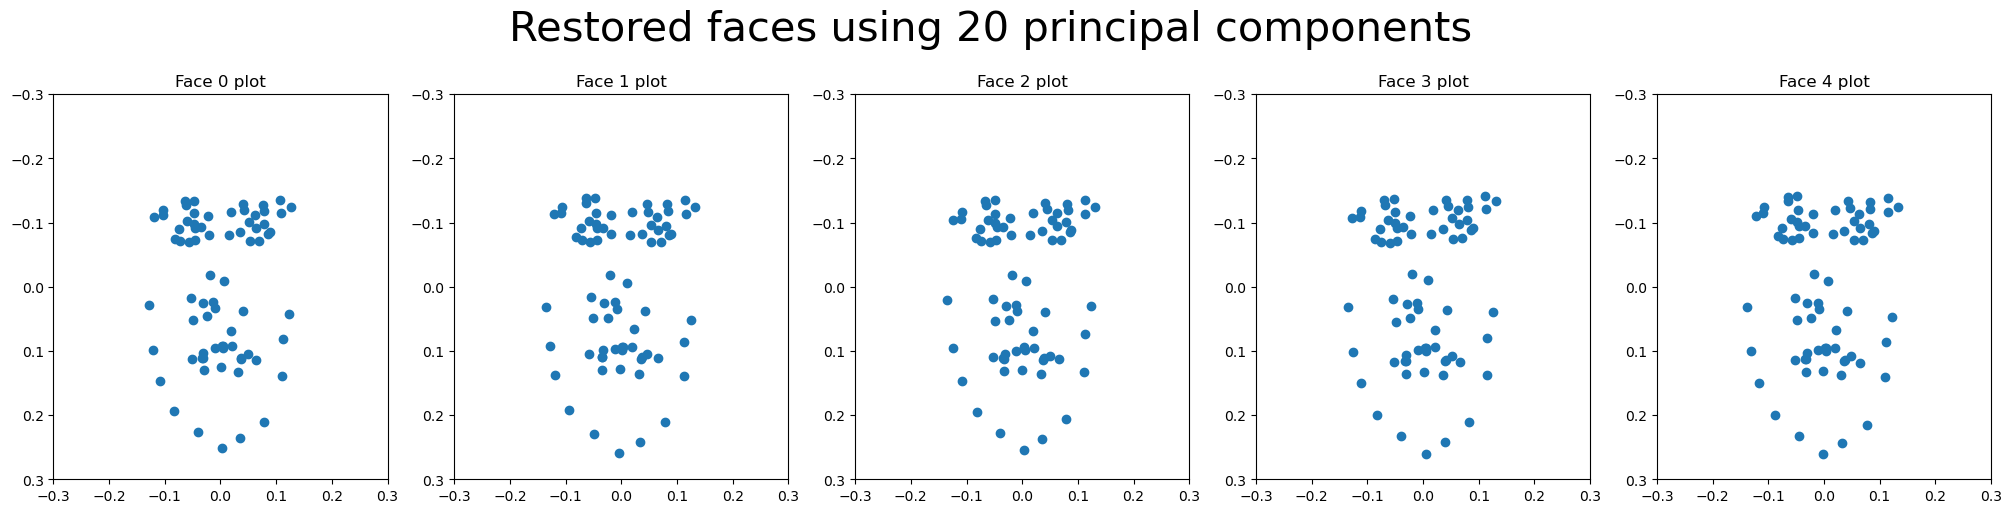

In [172]:
# Implementation for A)
# Get the principal components for the dataset and transform the faces to feature space.
# Uncomment below when you have copied your implementation

path = './db/'
shapes, images = face_shape_data(path)
#########################################################################
comp, val, mu = get_principle_components(shapes)

n_components = 20

print("compshape", comp.shape)
used = comp[:, :n_components]
print("usedshape", used.shape)
print("usedshape[:len(x)]", used[:len(shapes[:5])].shape)
print(shapes[:5].shape)


plot_many_faces(shapes[:5],"Original face shapes")
transformed = transform(shapes[:5], used, mu)
restored = inverse_transform(transformed, used, mu)
plot_many_faces(restored,"Restored faces using " + str(n_components) + " principal components")


B): 
- {{ task-code }} **Generate vectors:** Create a zero vector with $5$ dimensions, i.e. $b = [0, 0, \dots, 0]$. This will be your starting point. 
- {{ task-code }} **Shape generation:** Use $x = \Phi_{:5} b + \mu$ to generate a vector in real space from the zero vector (you may reuse the implementation from the exercise). Use the provided utility function `plot_face` to visualise the generated face as a plot.


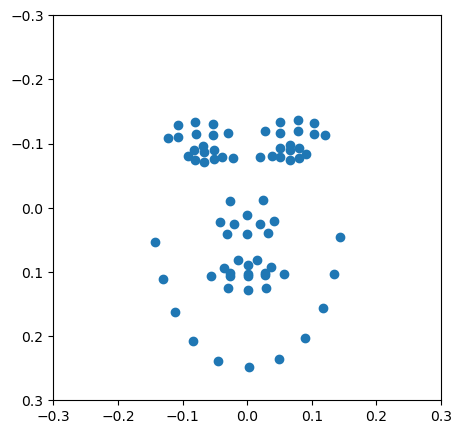

In [173]:
# Implementation for B)

comp, val, mu = get_principle_components(shapes)
n_components = 5
empty5d = np.zeros(n_components)
used = comp[:, :n_components]

generatedFace = inverse_transform(empty5d, used, mu)
generatedFaceMu = generatedFace + mu

plot_face(generatedFaceMu)

#std = transformed.std(axis=1)

C): {{ task-written }} **Base face:** Describe what the face generated using the zero vector represents and why this is the case. You should be able to deduce why from your knowledge about PCA.

**{{ answer }} Answer**

From what I see on the plotted graph, the face generated seems to be the "average" face. This idea is further reinforced when looking at how it is generated. As the zero-vector is used as the transformed face, the inverse transformation itself does not change the values (multiplication by 0), but adding the mean values afterwards makes up all the changes. So, the resulting component values are all the average values for each component, thus resulting in the components/dimensions of the generated face to be the average of the 120 faces used in the PCA.

+++

D): 
- {{ task-code }} **Varying components:** Start experimenting with changing the vector component values and watch the effect it has on the output.
- {{ task-code }} **Component controls:** Interpolate 5 values in the range $[-3\sigma_1, 3\sigma_1]$ for the first component $y_1$, generate the faces and visualise them.


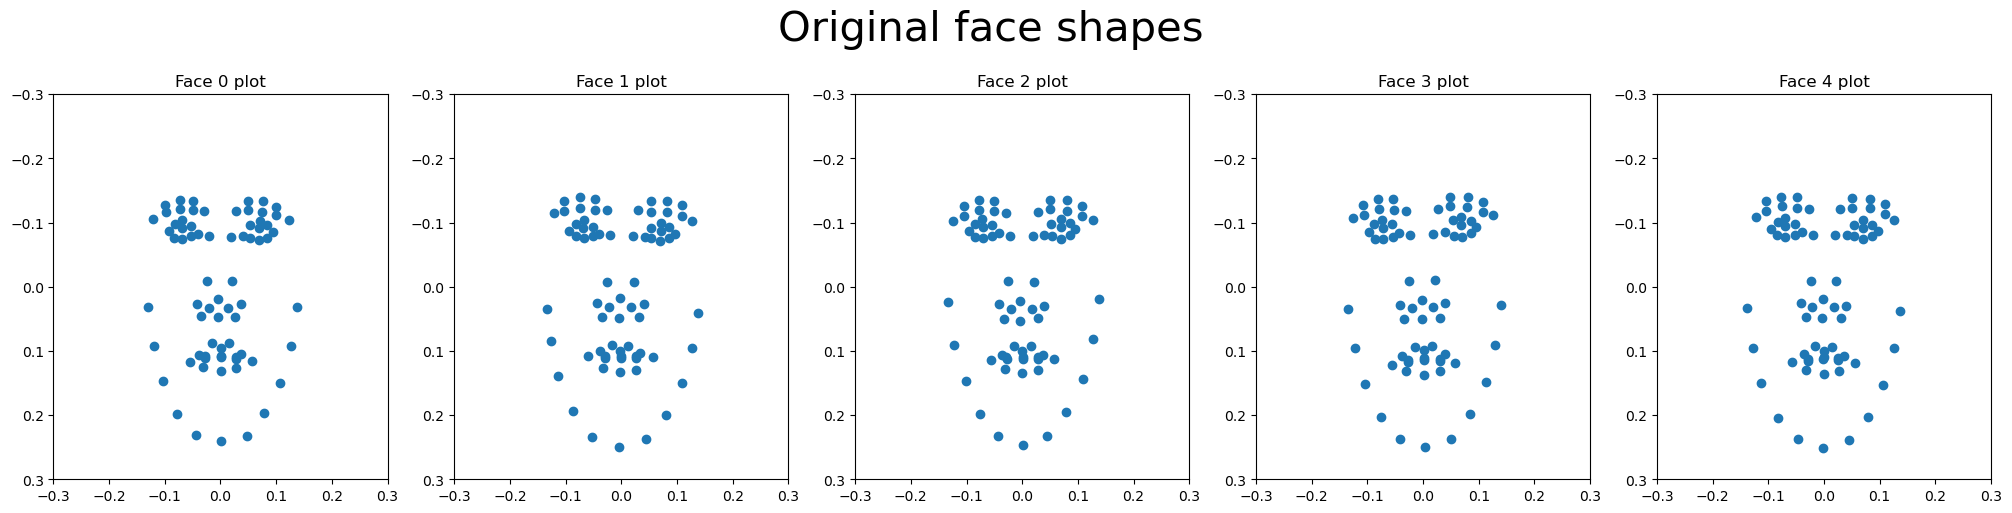

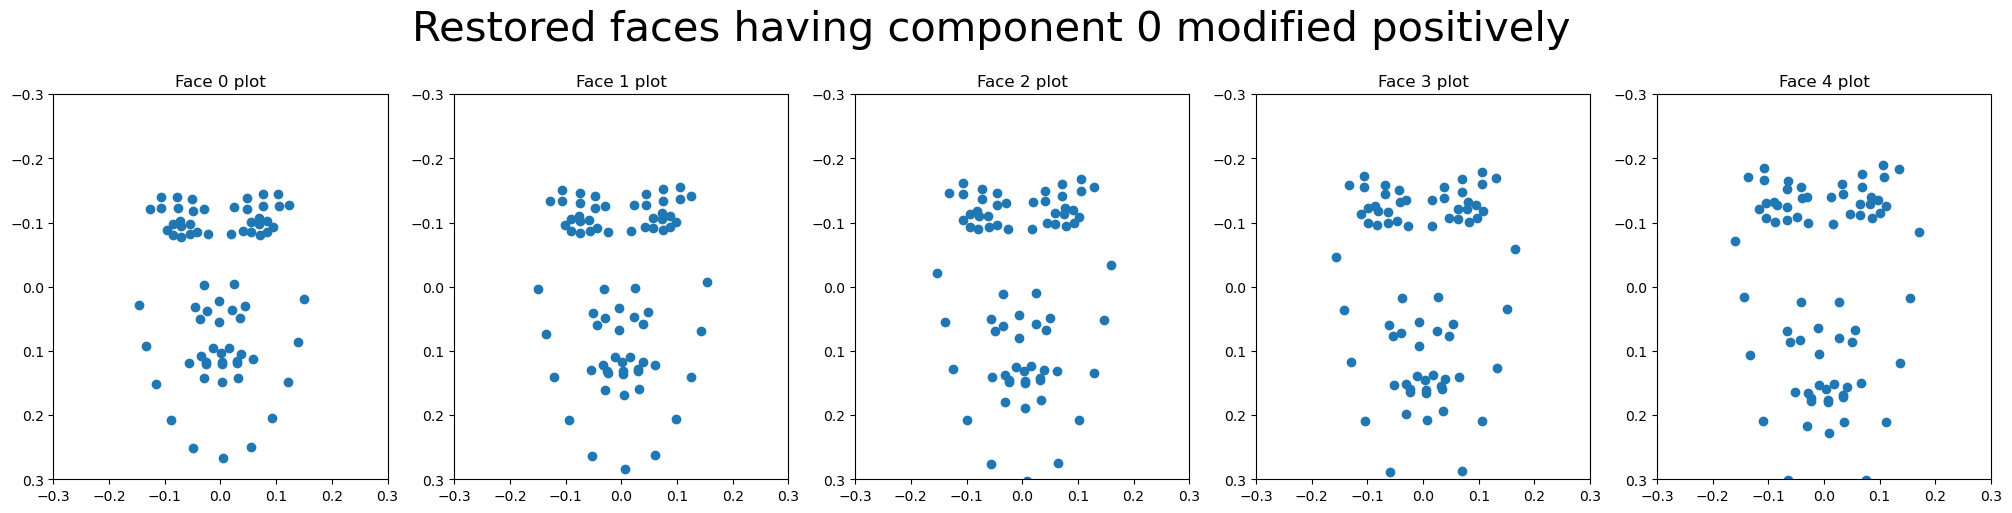

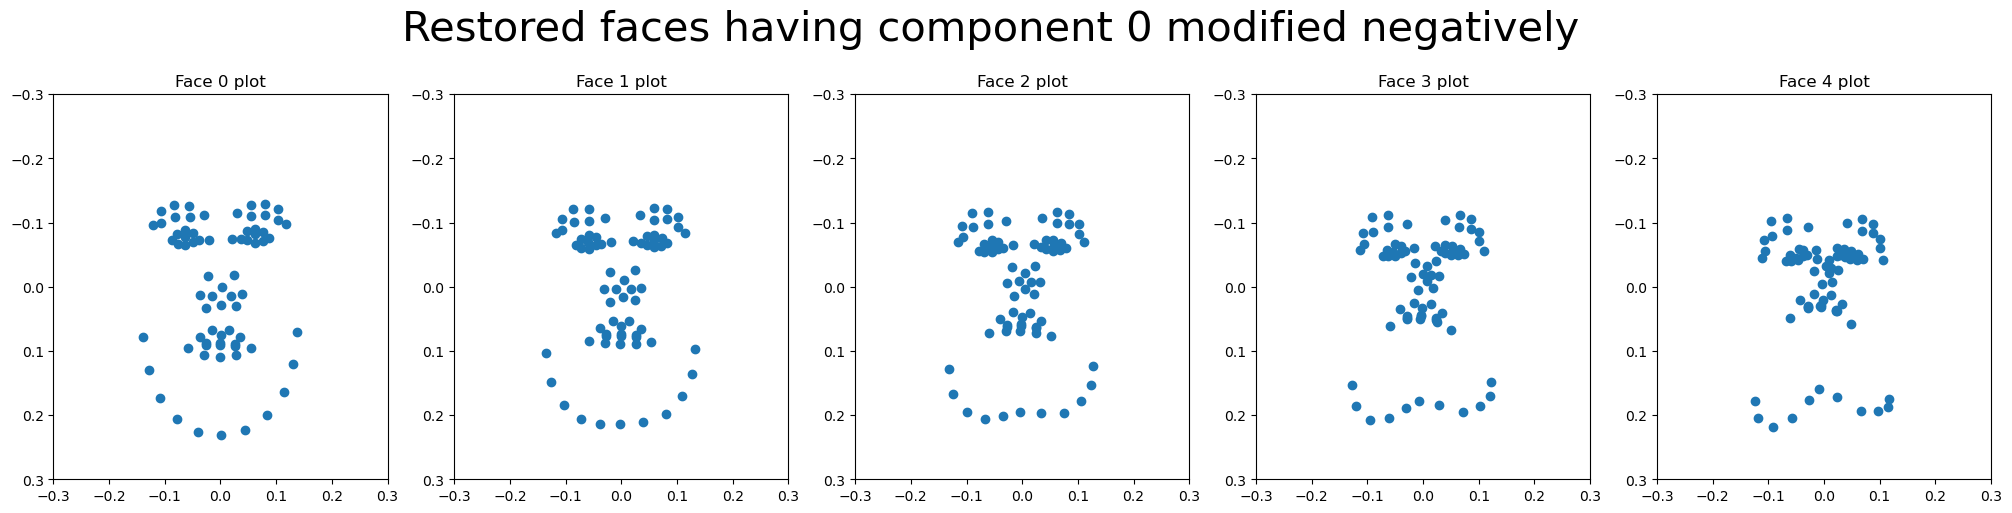

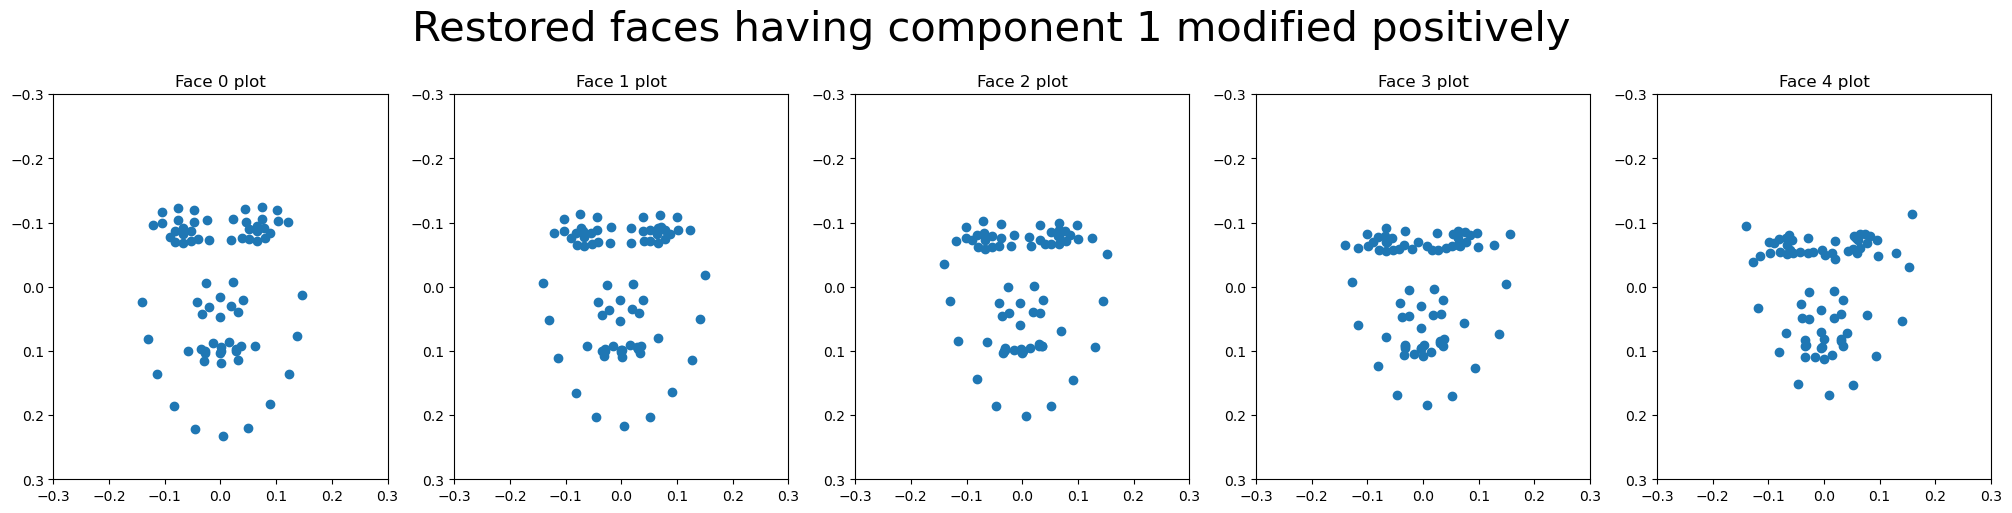

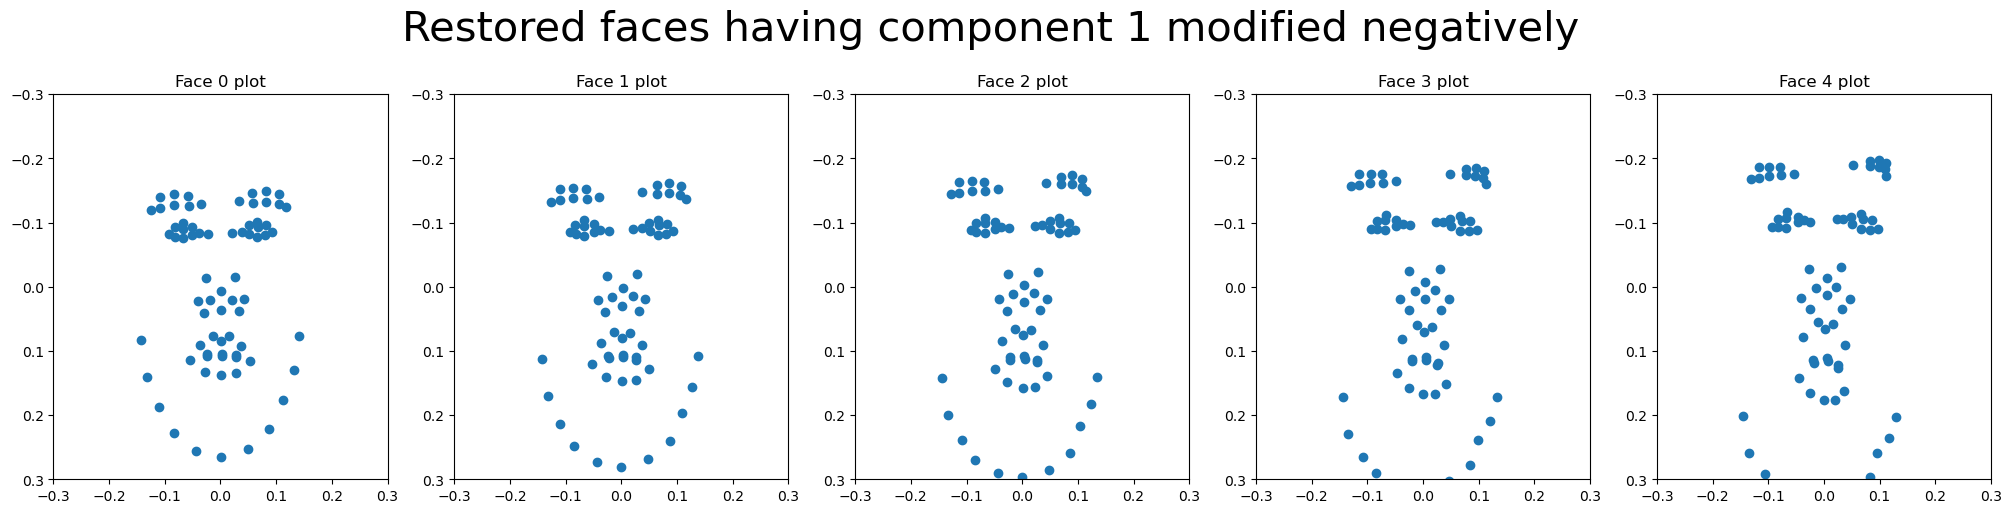

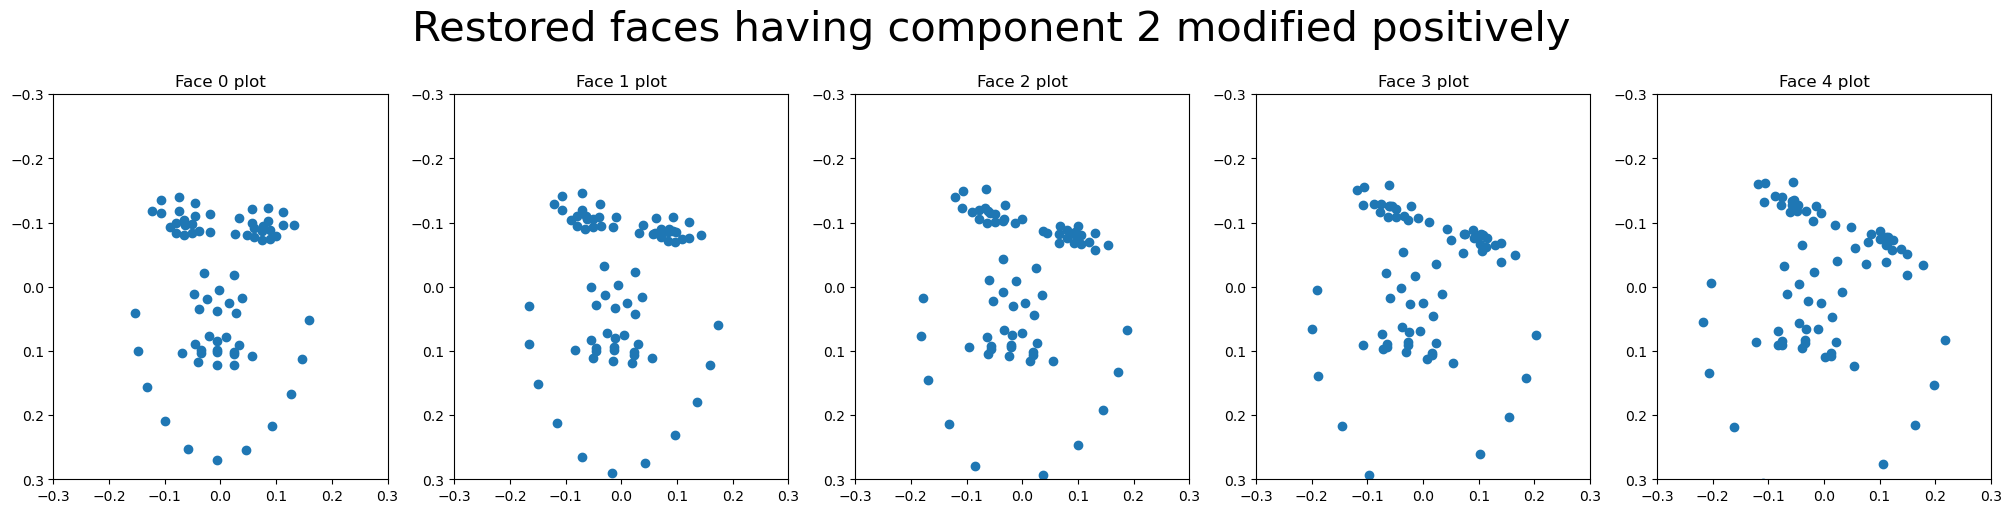

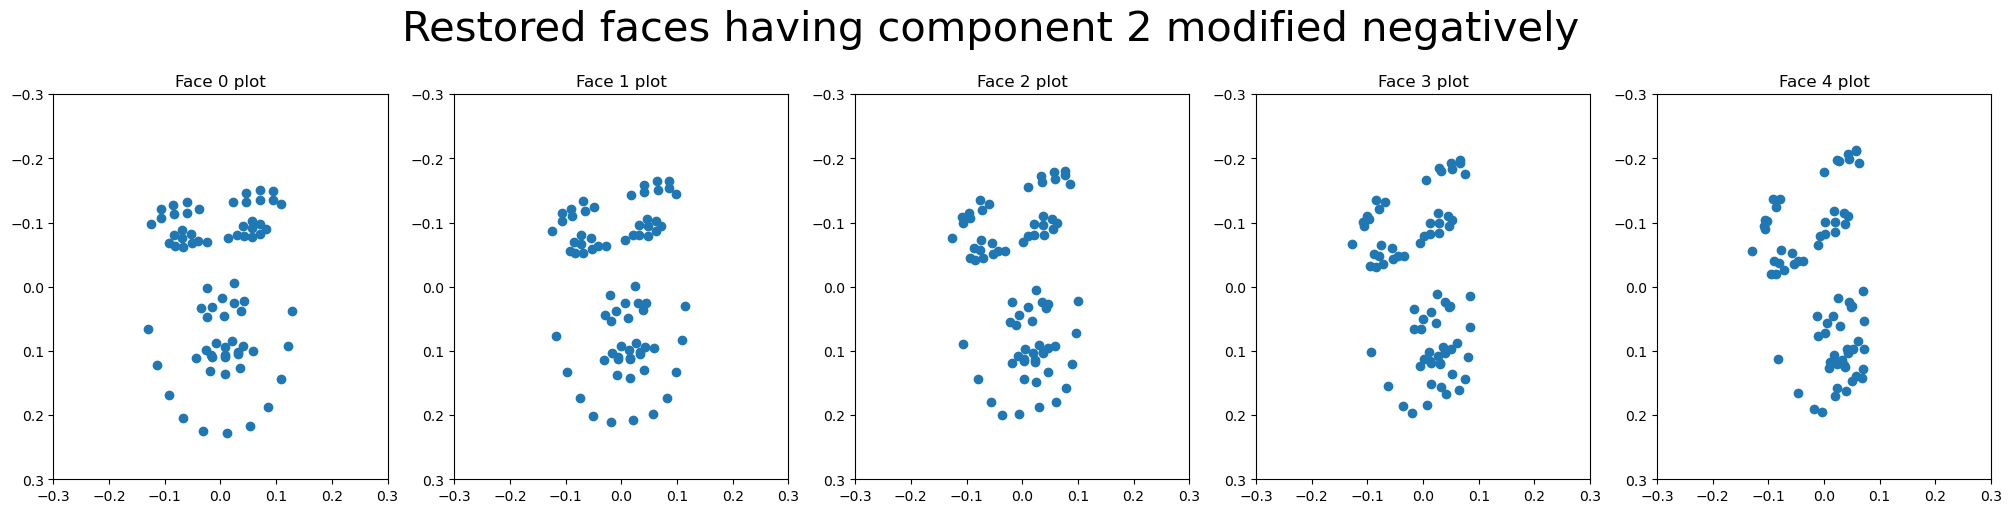

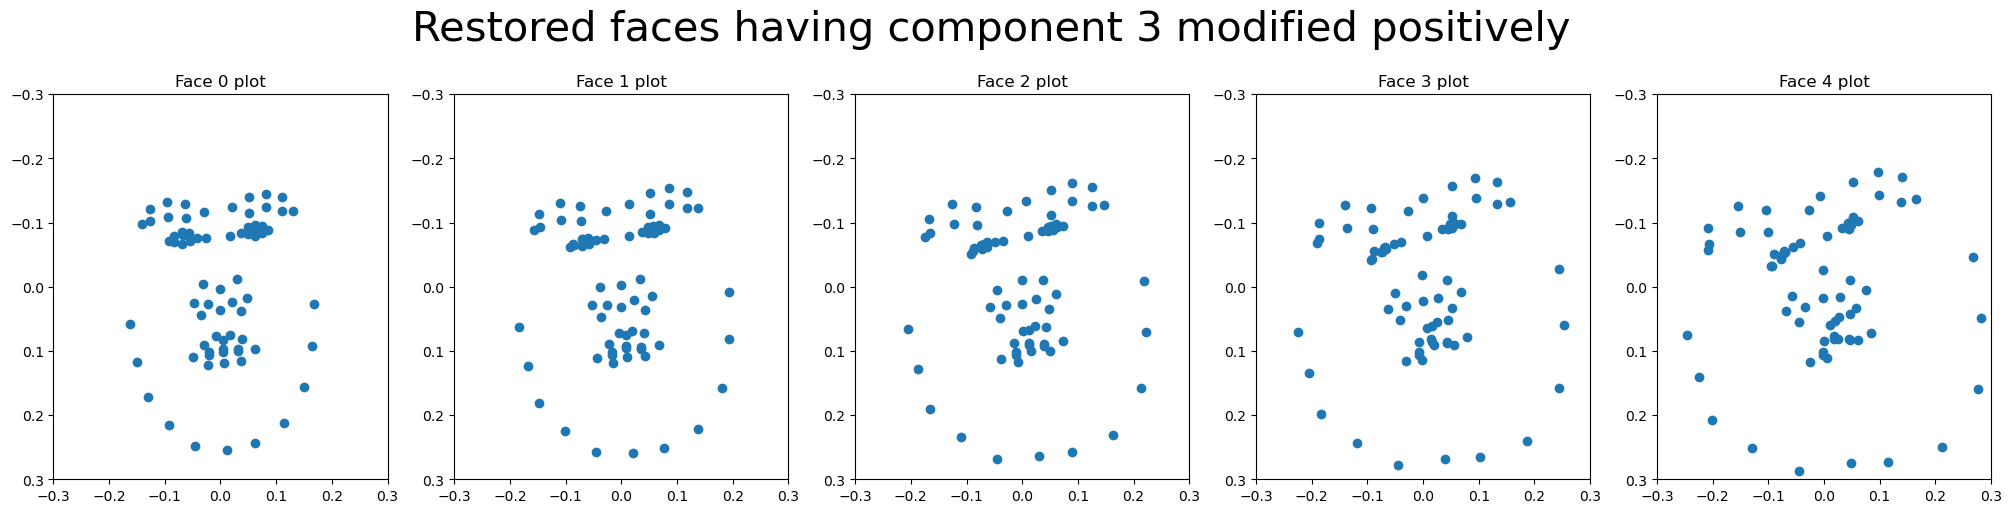

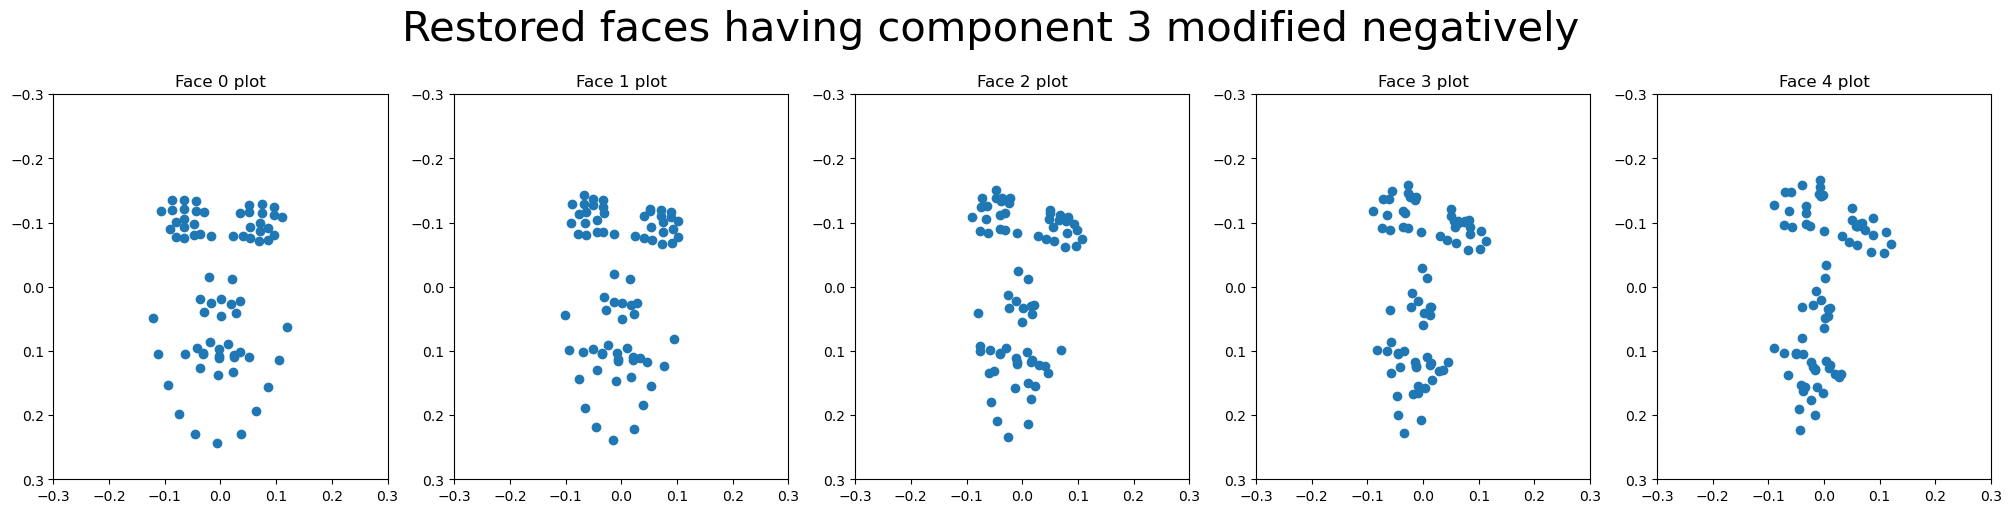

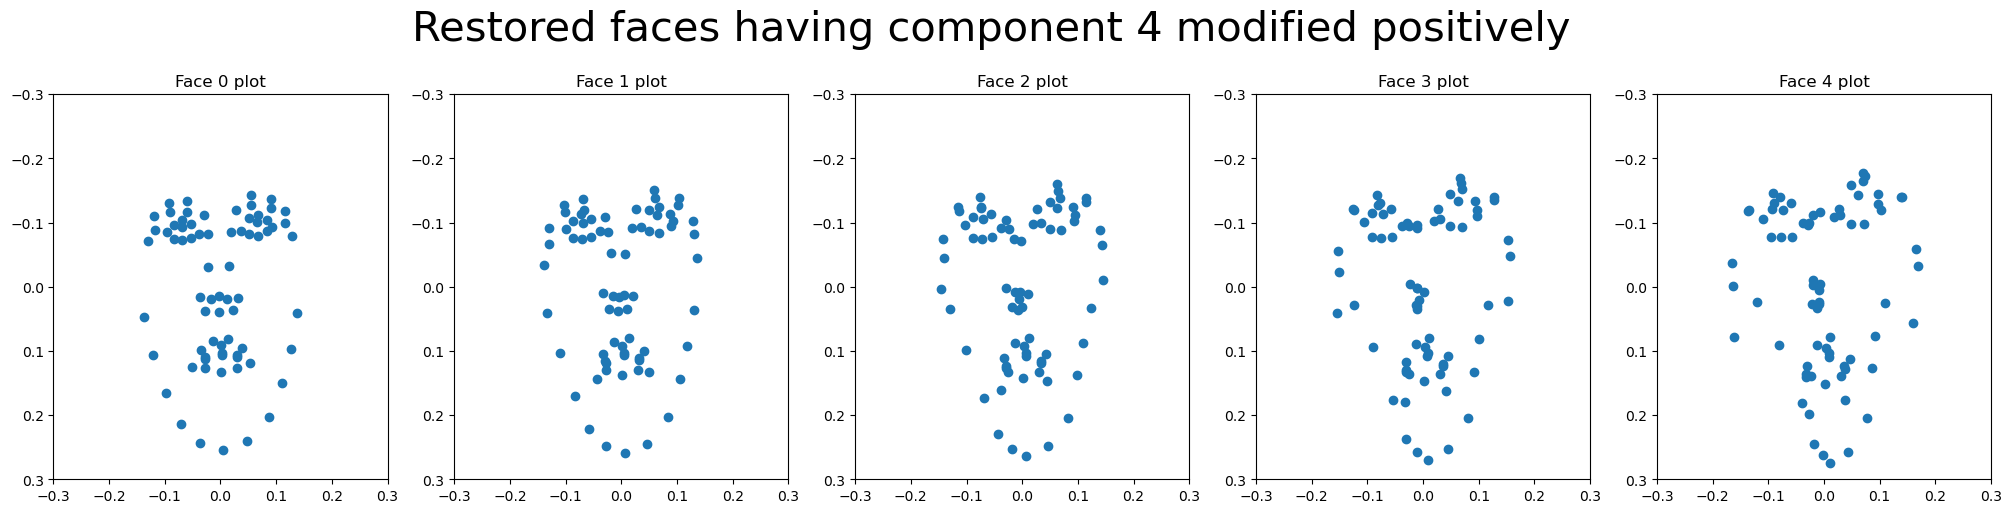

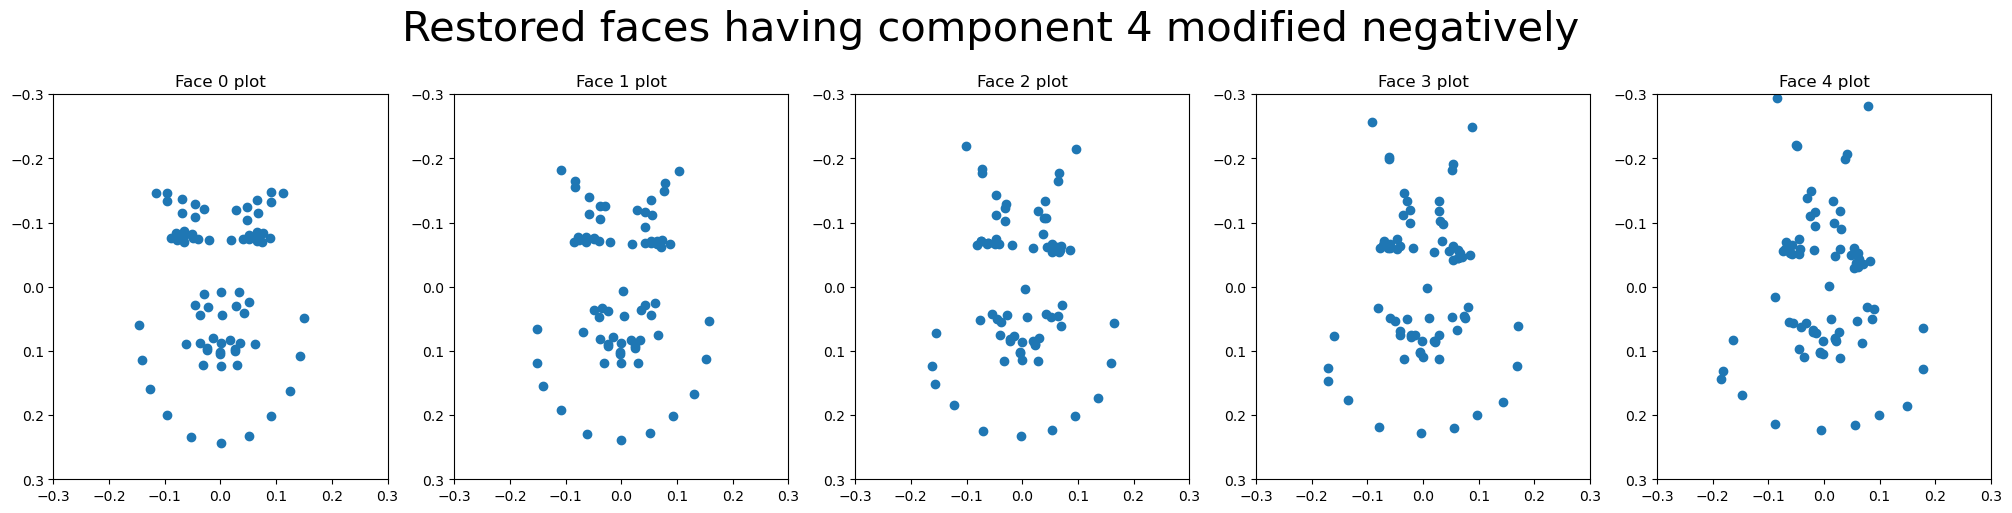

In [174]:
# Implementation for first part of D)

comp, val, mu = get_principle_components(shapes)
n_components = 5
used = comp[:, :n_components]
nFaces = 5
modification = 0.1

plot_many_faces(shapes[:nFaces],"Original face shapes")

for i in range(n_components):
    # Varying components, each face group having dimension i (vector component value) modified by different scalings of the modification value:
    allFacesP = []
    allFacesN = []
    for f in range(nFaces):
        zp = np.zeros(n_components)
        zp[i] = modification + (modification*f)

        generatedFaceP = inverse_transform(zp, used, mu) + mu
        allFacesP.append(generatedFaceP)

        zn = np.zeros(n_components)
        zn[i] = -modification - (modification*f)

        generatedFaceN = inverse_transform(zn, used, mu) + mu
        allFacesN.append(generatedFaceN)

    allFacesP = np.array(allFacesP)
    allFacesN = np.array(allFacesN)

    plot_many_faces(allFacesP, "Restored faces having component " + str(i) + " modified positively")
    plot_many_faces(allFacesN, "Restored faces having component " + str(i) + " modified negatively")



In [167]:
# Implementation for second part of D and E)


E): {{ task-writing }} **More components:** Do the same for each of the next four components, i.e. $b_2$-$b_5$. Write down what each component changes in the image (for example, the first component may change the height of the face). 

**{{ answer }} Answer**

Component changes:

1: This seems like it rotates the face up or downwards. Having a positve value sees the face more from "below" (as seen from the chin being more pointy), while having a negative value sees the face more from "above" (as seen from the chin being more round)

2: This seems like it streches the elements of the face vertically. Having a positive value clumps it together towards the same point, while having a negative value streches it apart.

3: This seems like it rotates or almost shears the face to the right with positive values, and to the left with negative values

4: This seems like it streches the elements of the face horizontally. Having a positive value streches it apart, while having a negative value clumps it together towards the same point.

5: This seems like it streches the face horizontally differently based on the points having a positive or negative y-value. Having a positive component modification, negative y-values gets streched and positive y-values gets clumped. Oppositely, having a negative component modification, negative y-values gets clumped and positive y-values gets streched.


F): {{ task-writing }} **Extreme values:** What happens if you select values outside the suggested range. Explain why this happens.

**{{ answer }} Answer**

...

+++

G): {{ task-code }} **Transform data:** Use $\Phi_{:k}^\top$ to transform the database faces into feature-space (using $x' = \Phi_{:k}^\top(x-\mu)$).

In [175]:
# Implementation for G)
comp, val, mu = get_principle_components(shapes)

n_components = 20

used = comp[:, :n_components]

#plot_many_faces(shapes[:5],"Database faces")
transformed = transform(shapes, used, mu)
#restored = inverse_transform(transformed, used, mu)
#plot_many_faces(transformed,"Transformed faces into feature space: " + str(n_components))


H): {{ task-code }} Plot the two first components in latent space using a scatterplot.
- {{ task-writing }} What does this plot tell you about the distribution of faces?
- {{ task-writing }} Experiment with showing different components. Describe how the plot changes.

**{{ answer }} Answer**

The plot tells me how the 120 faces are distributed in terms of their first two component values. Because we only visualise two values, it becomes possible to plot them in a 2d xy graph, and we can see how the faces are different on these particular component values. It can be seen that generally the distribution along the y-axis (the 2nd component) is more clumped up than the distribution along the x-axis (the 1st component), as the points seems more widely spread than tall. 

Choosing different components shows how some are more closely distributed.

For example, in the second graph drawn, the 3rd and 4th component values are visualised. Here it can be seen that the values are distributed much more closely in terms of both axes, compared to the 1st and 2nd component values. There are a few outliers here and there, but the points are still distributed rather closely.

In the third graph shown, the 1st and 20th component values are visualised. Here it is even more obvious how the 20th component values are distributed way more closely than those of the 1st component (the y-axis values are way smaller). This tells us that this dimension of the faces is not varying nearly as much as the 1st dimension is.

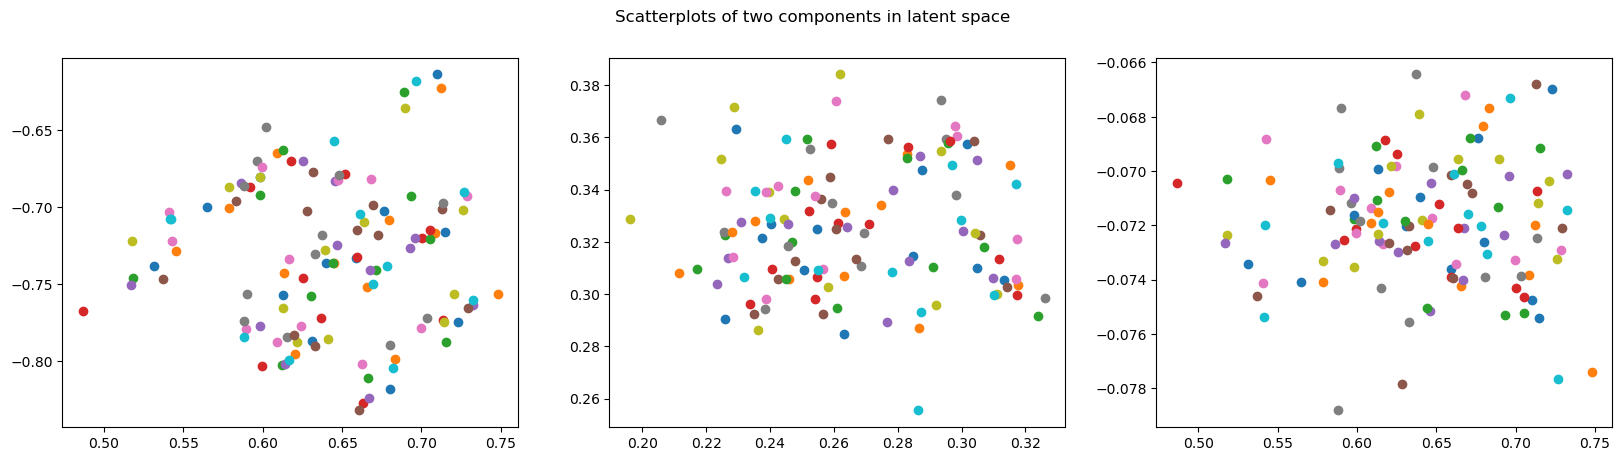

In [187]:
# Implementation for H)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle("Scatterplots of two components in latent space")
fig.set_figwidth(20)
for i in range(len(transformed)):
    ax1.scatter(transformed[i][0], transformed[i][1])
    ax2.scatter(transformed[i][2], transformed[i][3])
    ax3.scatter(transformed[i][0], transformed[i][19])



I): {{ task-code }} **Shape Interpolation:** Create two faces by selecting two points in latent space, try to select two points far from each other in latent space, but not creating unrealstic faces. You can choose the number of components non-zero values. Now you should `np.linspace` to interpolate between the two points. Use `num` to control the number of output values. Plot the resulting faces. Below is an example of how to interpolate two vectors.


Euclidian distance of two furthest points: (0.27107643223137656, (93, 10))


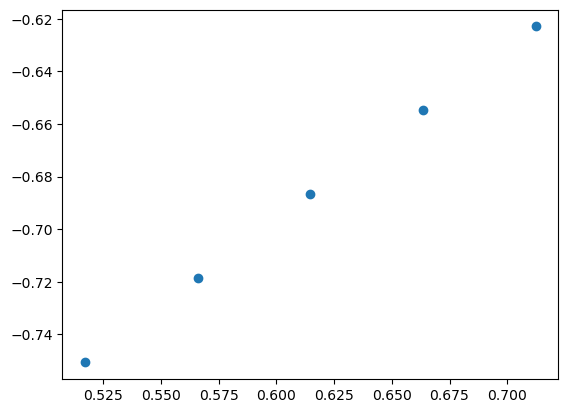

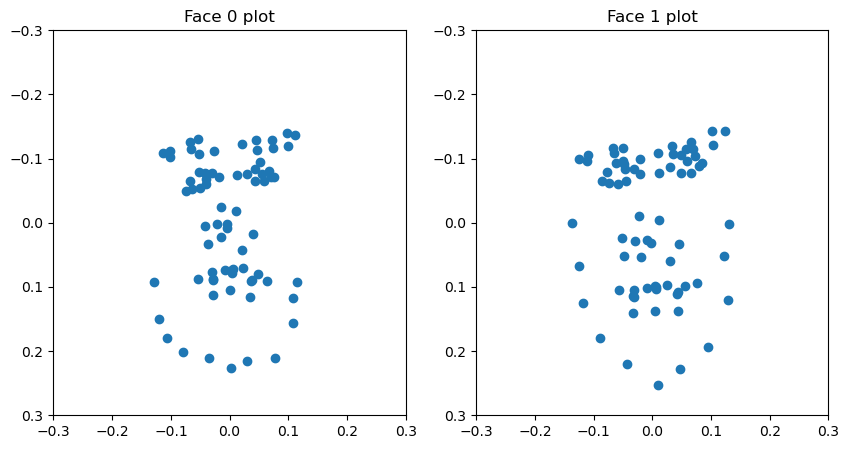

In [225]:
## linspace example 
#d = np.linspace(np.array([1, 2]), np.array([3, 5]), num=5)
#plt.scatter(d[:, 0], d[:, 1])

## write your own implementation here
# Just for fun, I tried finding the two points furthest away from each other using euclidian distance
eu = []
for i in range(len(transformed)):
    for j in range(len(transformed)):
        euclidian = np.sqrt(np.power(abs(transformed[i][0]-transformed[j][0]), 2) + np.power(abs(transformed[i][1]-transformed[j][1]), 2))
        eu.append((euclidian, (i, j)))

print("Euclidian distance of two furthest points:", sorted(eu, reverse=True)[0])

# I then used the two points found for my face generation
point1 = np.array([transformed[94][0], transformed[94][1]])
point2 = np.array([transformed[11][0], transformed[11][1]])
d = np.linspace(point1, point2, num=5)
plt.scatter(d[:, 0], d[:, 1])

# Generating faces for each selected point (with all components from latent space)
generatedFace1 = inverse_transform(transformed[94], used, mu)
generatedFace2 = inverse_transform(transformed[11], used, mu)
plot_many_faces([generatedFace1, generatedFace2])


J): {{ task-writing }} **Behaviour:** Assume a set of points on a line in latent space. Argue for why the same set of points, when mapped to real space using $x = \Phi_{:k}b + \mu$ also lie on a line.

**{{ answer }} Answer**

...

+++

(pca:reflect)=
## {{ mandatory-task }} Reflection
Describe and reflect on the results gathered from various parts of the exercises for week 10 (including the non-mandatory ones). Answer the following questions (and back up your arguments with results or theory)

A): {{ task-writing }} What did you think of the results from the generative model? Explain why so few principal components are needed to reproduce the samples quite accurately.
  
**{{ answer }} Answer**

...

 
B): {{ task-writing }} How many components do you need to have $50\%$, $60\%$, $80\%$, $95\%$ of the total variation?

**{{ answer }} Answer**

...
